# Bildverarbeitung Verkehrszeichenerkennung - Validation Pipeline

## Funktionen definieren
In der foldenden Codezelle sind Funktionen definiert, die bei der Untersuchtung der Batches hilfreich sind. Anpassungen der Funktion werden so für jeden Batch übernommen.

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import math
import os
import random

#Diese Funktion gibt Vorhersagen des geladenen Modells zurück
def predictDataset(dataset):
    test_ds = dataset["dataset"]
    test_labels = dataset["test_lables"]
    predictions = model.predict(test_ds)


    predictions = np.argmax(predictions, axis=1)

    for i in range(0, len(predictions)):
        predictions[i] = int(train_class_names[predictions[i]])


    # print("Predictions: ", predictions)
    # print("Ground truth: ", test_labels)
    return  predictions

#Hier sind die Metriken definiert
def accuracy(predictions, test_labels):
    metric = tf.keras.metrics.Accuracy()
    metric.update_state(predictions, test_labels)
    return metric.result().numpy()

#Diese funktion zeigt bis zu 15 zufällige flasch erkannten Bilder eines Test Datensatzes an
def plotFalsePics(predictions, dataset, paths):
    paths_2_plot = []
    descriptions = []
    for picture in range(0, len(predictions)):
        if(predictions[picture] != dataset["test_lables"][picture]):
            paths_2_plot.append(paths[picture])
            descriptions.append("Picture Nr.: " + str(picture) + " predicted as: \n" + str(class_names_df["SignName"][predictions[picture]]))

    paths_2_plot_tmp = []
    descriptions_tmp = []
    if(len(paths_2_plot) > 15):
        for i in range(15):
            rand_number = random.randint(1, len(paths_2_plot))
            paths_2_plot_tmp.append(paths_2_plot[rand_number])
            descriptions_tmp.append((descriptions[rand_number]))
        paths_2_plot = paths_2_plot_tmp
        descriptions = descriptions_tmp

    num_images = len(paths_2_plot)
    rows = (num_images - 1) // 5 + 1
    fig, axs = plt.subplots(rows, 5, figsize=(15, 3 * rows))
    axs = axs.flatten()

    for i, path in enumerate(paths_2_plot):
        img = Image.open(path)
        ax = axs[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(descriptions[i])

    if num_images % 5 != 0:
        for j in range(num_images % 5, 5):
            axs[-j].axis('off')

    plt.tight_layout()
    plt.show()

#Diese Funktion speichert die Pfade der Test Bilder, sodass ein geordneter Zugriff möglich ist
def get_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

#Diese Funktion plottet ein Häufigkeitsdiagramm der falsch erkannten Schilder Typen
def frequencyChartPlot(predictions, test_labels, plot):
    predictions2plot=[]

    if(plot == "recogized_as"):
        predictions2plot = predictions
        plt.title('recogized_as')

    elif(plot == "false_singns"):
        plt.title('false_singns')
        for pred_num in range(0, len(predictions)):
            if(predictions[pred_num] != test_labels[pred_num]):
                predictions2plot.append(test_labels[pred_num])
    else:
        print("Please set recogized_as or false_singns")
        return

    # colors = plt.cm.Set2(np.linspace(0, 1, 39))  # Farbpalette für 10 verschiedene Farben
    plt.hist(predictions2plot, bins=np.arange(-0.5, 39.5, 1), rwidth=0.9)
    plt.xticks(range(39))

    # Beschriftung der Achsen und des Diagramms
    plt.gcf().set_size_inches(12, 6)  # Setzen der Größe des Diagramms
    plt.xlabel('Zahlen')
    plt.ylabel('Häufigkeit')

    # Darstellung der Zahlen auf den Balken
    for i in range(39):
        if(np.bincount(predictions2plot)[i] != 0):
            plt.text(i + 0.4, np.bincount(predictions2plot)[i] + 0.5, str(np.bincount(predictions2plot)[i]))

    # Anzeigen des Diagramms
    plt.show()


## Laden des Modells und der Test Datensätze
Zunächst wird das Standardmodell genutzt, um alle Test Batches zu bearbeiten und deren Schwachstellen aufzudecken. Dafür werden zuerst das Modell und alle Datensätze geladen.

In [3]:
batch_size = 32
img_height = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3
img_width = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3

#Laden des Modells
print("Loading model")
model_name = "Model_V0_E50S96"
import_path = "./trained_models/{}".format(model_name)
model = tf.keras.models.load_model(import_path)

#Laden der Trainingsdaten
print("Loading train data")
train_data_root = "./GTSRB_dataset/Train/"
train_ds = tf.keras.utils.image_dataset_from_directory(train_data_root)
train_class_names = np.array(train_ds.class_names)

#Laden der Testdaten (Batches)
class_names_df = pd.read_csv("./signnames.csv", index_col="ClassId")

print("loading validation data")
val_data_roots = ["./safetyBatches/Batch_0/",
                  "./safetyBatches/Batch_1/",
                  "./safetyBatches/Batch_2/",
                  "./safetyBatches/Batch_3/",
                  "./safetyBatches/Batch_4/",
                  "./safetyBatches/Batch_5/",
                  "./MyTestBatch"]

val_data_paths = []
for val_data_path in val_data_roots:
    val_data_paths.append(get_image_paths(val_data_path))

test_datasets = []
for val_data_root in val_data_roots:
    test_ds  = unedited_dataset = tf.keras.utils.image_dataset_from_directory(
        val_data_root,
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=False,
    )
    class_names = np.array(test_ds.class_names)

    test_labels = np.concatenate([y for x, y in test_ds], axis=0)
    for i in range(0, len(test_labels)):
        test_labels[i] = int(class_names[test_labels[i]])

    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

    test_ds = test_ds.map(
        lambda x, y: (normalization_layer(x), y)
    )

    #Daten werden für einen einfacheren Umgang in ein Dictionary abgelegt
    val_data_dict = {
      "dataset": test_ds,
      "unedited_dataset" : unedited_dataset,
      "test_lables": test_labels}

    test_datasets.append(val_data_dict)

print("Finished")

Loading model
Loading train data
Found 39209 files belonging to 43 classes.
loading validation data
Found 17 files belonging to 5 classes.
Found 50 files belonging to 1 classes.
Found 2100 files belonging to 1 classes.
Found 39209 files belonging to 43 classes.
Found 210 files belonging to 1 classes.
Found 733 files belonging to 1 classes.
Found 8093 files belonging to 43 classes.
Finished


## Batch 0
Batch 0 beinhaltet nur weniger Bilder und ist daher zur Validierung eher ungeeignet. Dafür eignet es sich um Code zu Testen, da die Laufzeit des Modells durch die wenigen Bilder sehr schnell ist. Zudem beinhaltet es verschiedene Schildertypen.

Accuracy:  0.8235294


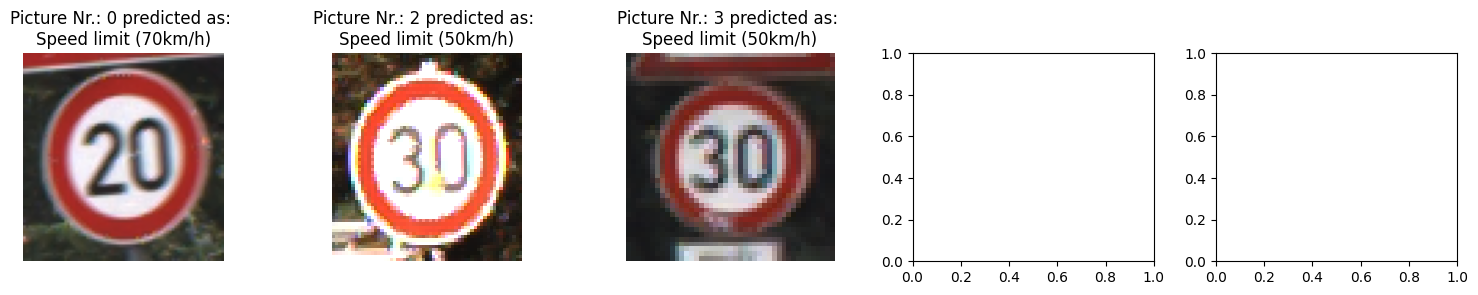

In [3]:
dataset_nr = 0
predictions = predictDataset(test_datasets[dataset_nr])
test_labels = test_datasets[dataset_nr]["test_lables"]

print("Accuracy: ", accuracy(predictions, test_labels))
plotFalsePics(predictions, test_datasets[dataset_nr], val_data_paths[dataset_nr])

Das Basis Modell erkennt die drei angezeigten Verkehrszeichen falsch. Wobei die Bilder augenscheinlich von ausreichender Qualität sind. Jedoch ist auffällig, dass die Schilder Geschwindigkeitsbegrenzungen sind und auch als solche erkannt werden, jedoch mit der falschen Geschwindigkeit. Eventuell könnte es hilfreich sein Training Datensätze zu erstellen, die aus den Zahlen der Schilder bestehen (ohne die rote Umrandung). Um weitere Schlüsse ziehen zu können sind mehr Testdaten nötig.

## Batch 1
Batch 1 besteht nur aus einem Schildtyp (Auflösung des Überholverbots für Fahrzeuge über 3,5 Tonnen). Für die Validierung der Bilderkennung ist eine Datensatz von nur einem Typen nicht ausreichend.

Accuracy:  0.98


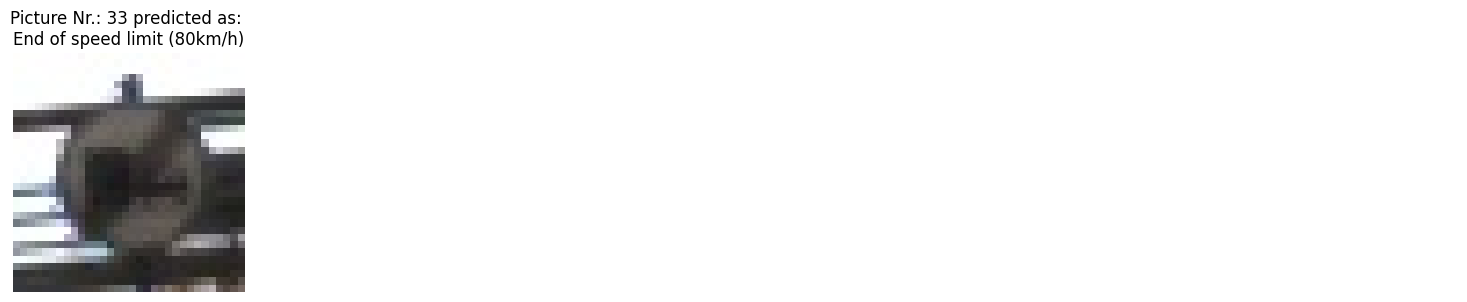

In [4]:
dataset_nr = 1
predictions = predictDataset(test_datasets[dataset_nr])
test_labels = test_datasets[dataset_nr]["test_lables"]

print("Accuracy: ", accuracy(predictions, test_labels))

plotFalsePics(predictions, test_datasets[dataset_nr], val_data_paths[dataset_nr])

Es wurde ein Bild nicht erkannt. Dieses ist jedoch auch von schlechter Qualität.

## Batch 2
Dieser Batch besteht ebenfalls nur aus einem Schlidtypen (Vorfahrtstrasse).

Accuracy:  0.98761904


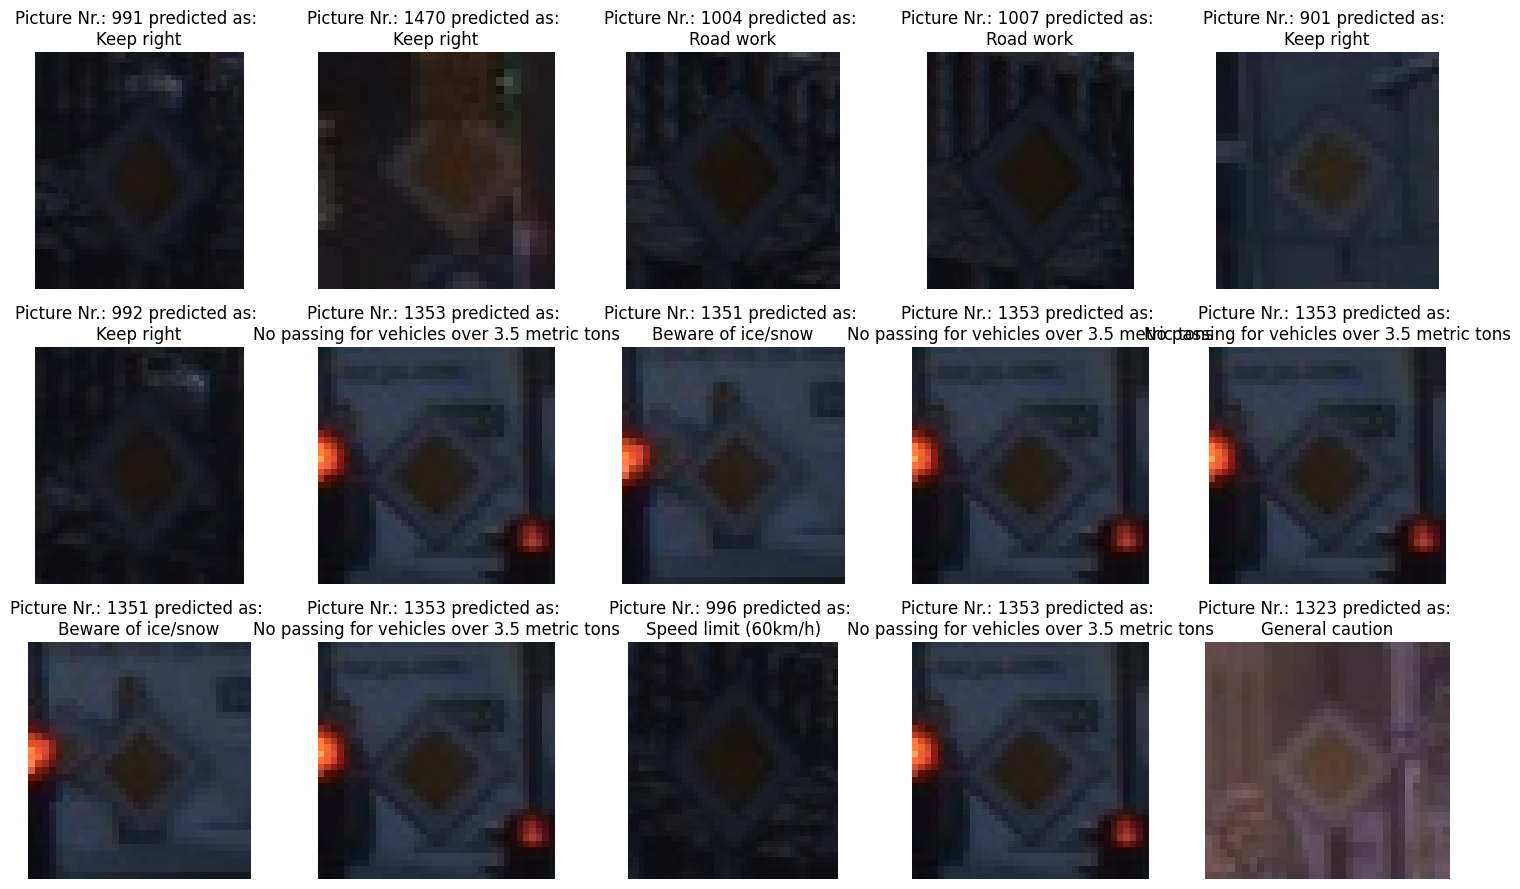

In [6]:
dataset_nr = 2
predictions = predictDataset(test_datasets[dataset_nr])
test_labels = test_datasets[dataset_nr]["test_lables"]

print("Accuracy: ", accuracy(predictions, test_labels))
plotFalsePics(predictions, test_datasets[dataset_nr], val_data_paths[dataset_nr])

Zu erkennen ist, dass alle Schilder die nicht erkannt wurde ziemlich dunkel und von schlechter Quallität sind. Das Trainingsset beinhaltet jedoch auch solche Bilder des Schilds. Eine Erweiterung der Trainingsdaten mit dunkleren Bildern könnte einen positiven Effekt haben.

## Batch 3
Bei der genaueren Betrachtung von Batch 3 fällt auch, dass dieses Testest genau den Trainingsdaten des GTSRB-Datensets entspricht. Wie bereits erläutert, ist es nicht zulässig ein Modell mit seinen Trainingsdaten zu Validieren.


Accuracy:  0.9868653


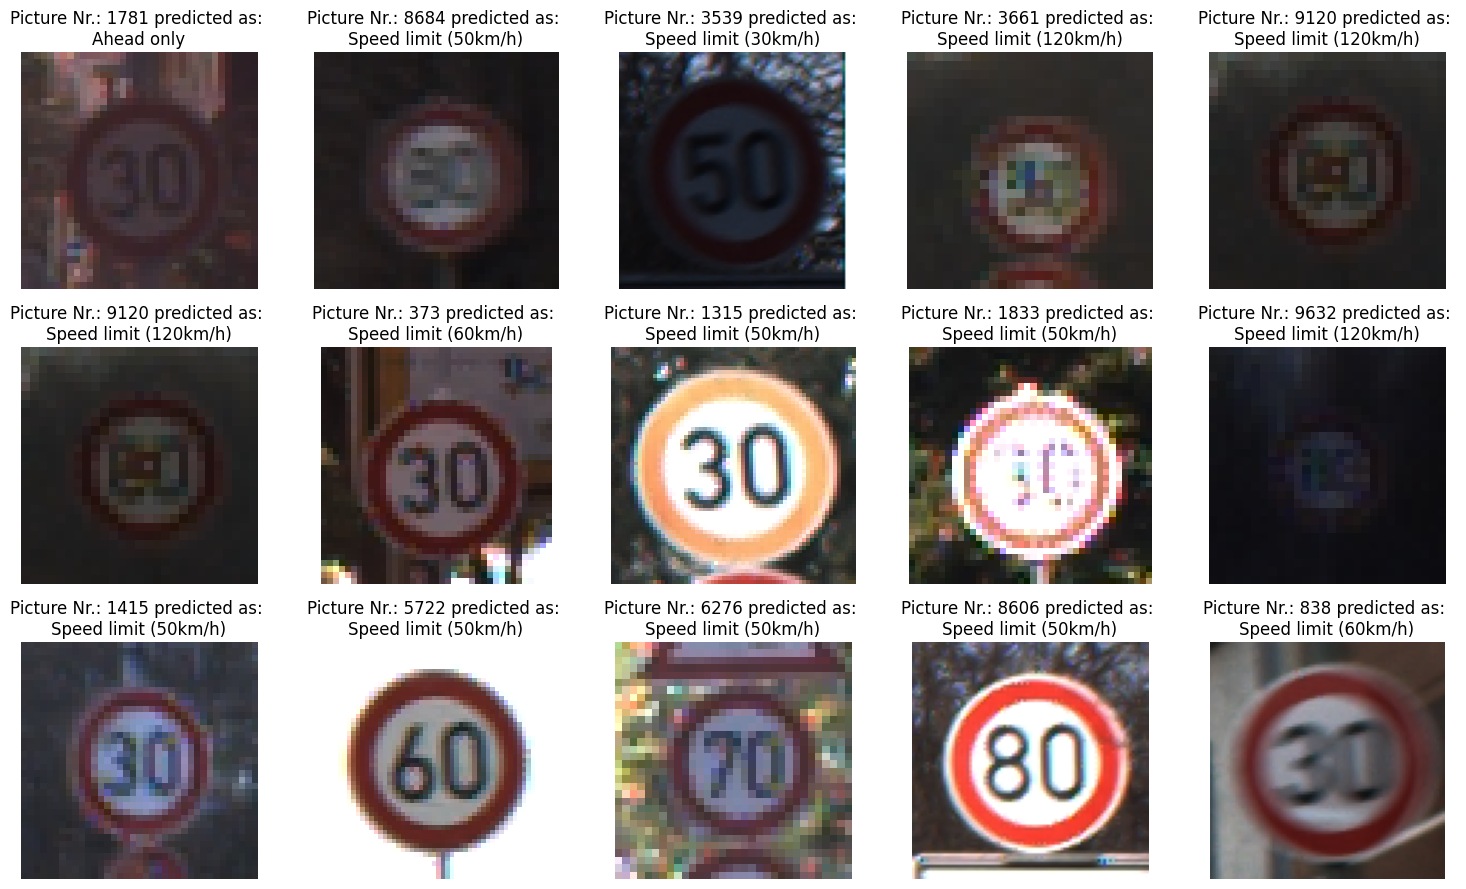

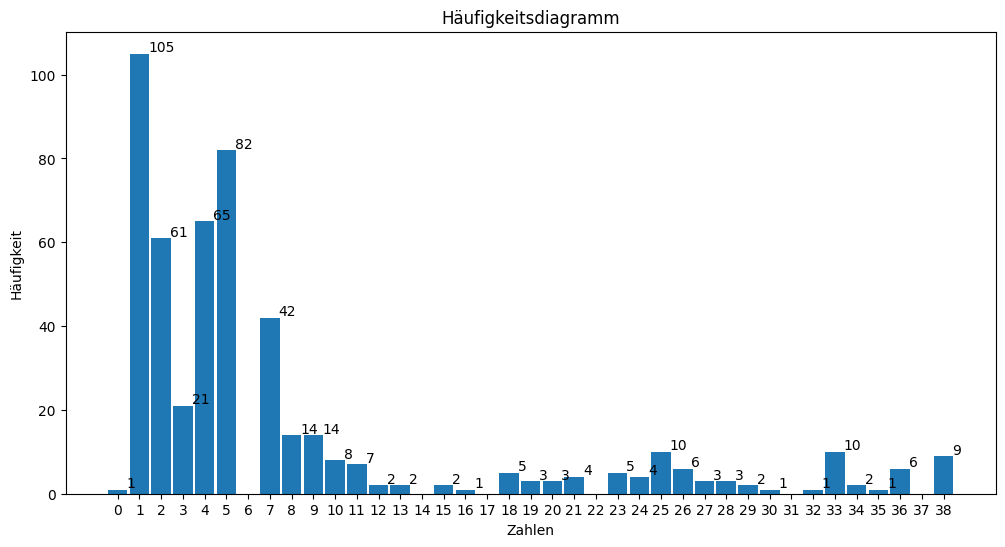

In [7]:
dataset_nr = 3
predictions = predictDataset(test_datasets[dataset_nr])
test_labels = test_datasets[dataset_nr]["test_lables"]

print("Accuracy: ", accuracy(predictions, test_labels))
plotFalsePics(predictions, test_datasets[dataset_nr], val_data_paths[dataset_nr])

frequencyChartPlot(predictions, test_labels, "false_singns")

Die Verkehrszeichen 0 bis 8 (mit Ausnahme von 6) sind Geschwindigkeitsbegrenzungen. Diese werden anscheinend öfter falsch erkannt als andere Verkehrszeichen, vermutlich weil diese sich ähnlich sehen. Um das Modell für die Zahlen der Schilder sensibler zu machen, könnte es von Vorteil sein, Training Datensätze die nur Zahlen beinhalten zu erstellen und das Modell erneut zu trainieren.

## Batch 4
Dieser Batch besteht nur aus 20er-Schildern. Diese sind jedoch alle sehr dunkel.

Accuracy:  0.0


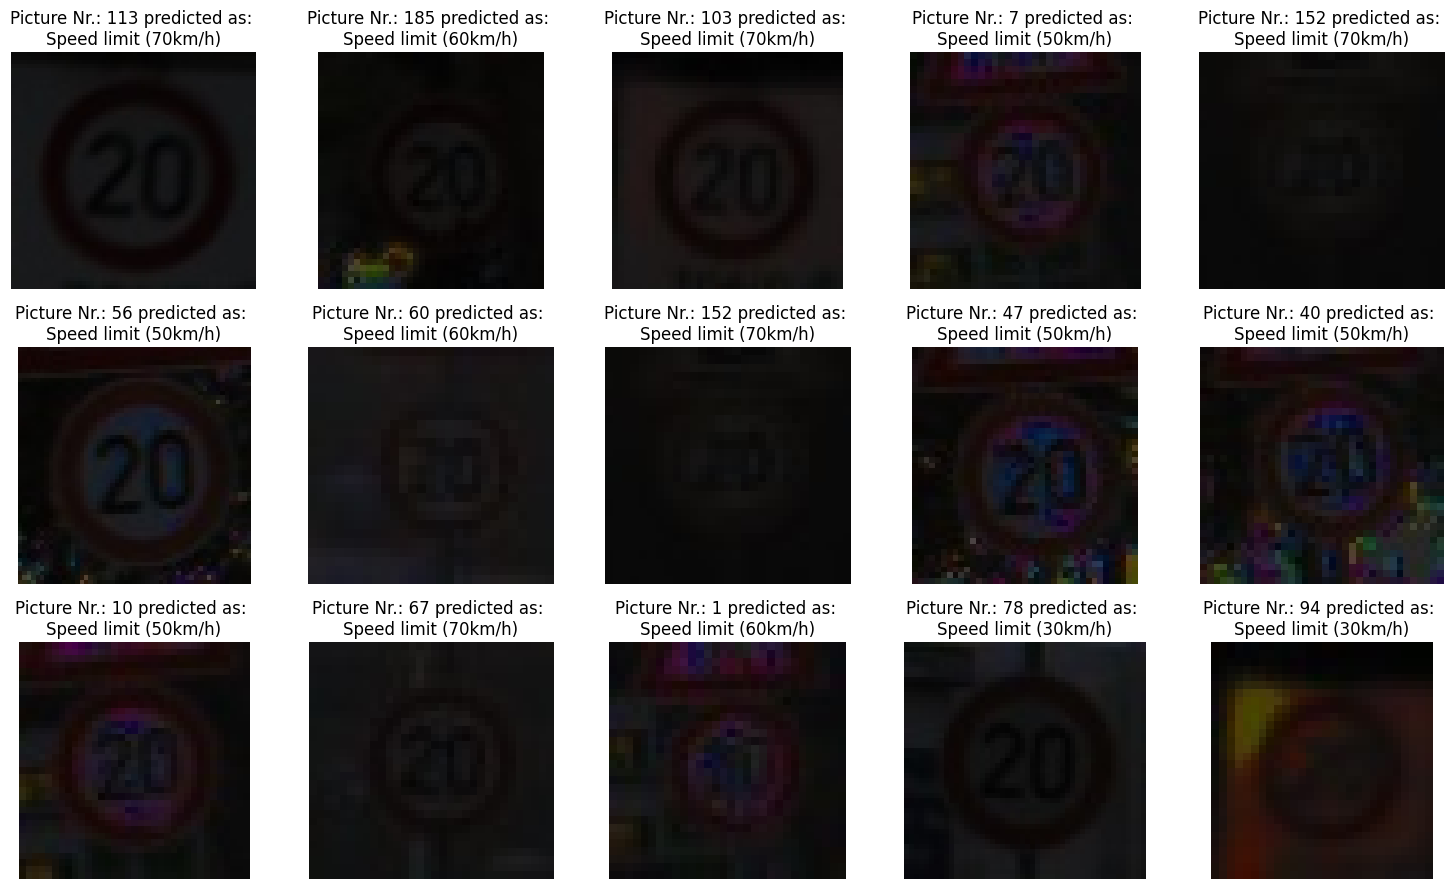

In [8]:
dataset_nr = 4
predictions = predictDataset(test_datasets[dataset_nr])
test_labels = test_datasets[dataset_nr]["test_lables"]

print("Accuracy: ", accuracy(predictions, test_labels))
plotFalsePics(predictions, test_datasets[dataset_nr], val_data_paths[dataset_nr])

Es wurde keines der Bilder korrekt erkannt. Beim Betrachten des Trainingssets fällt auf, dass es kein Bild eines 20er-Schildes umfasst das dunkel ist.

## Batch 5

Accuracy:  0.0


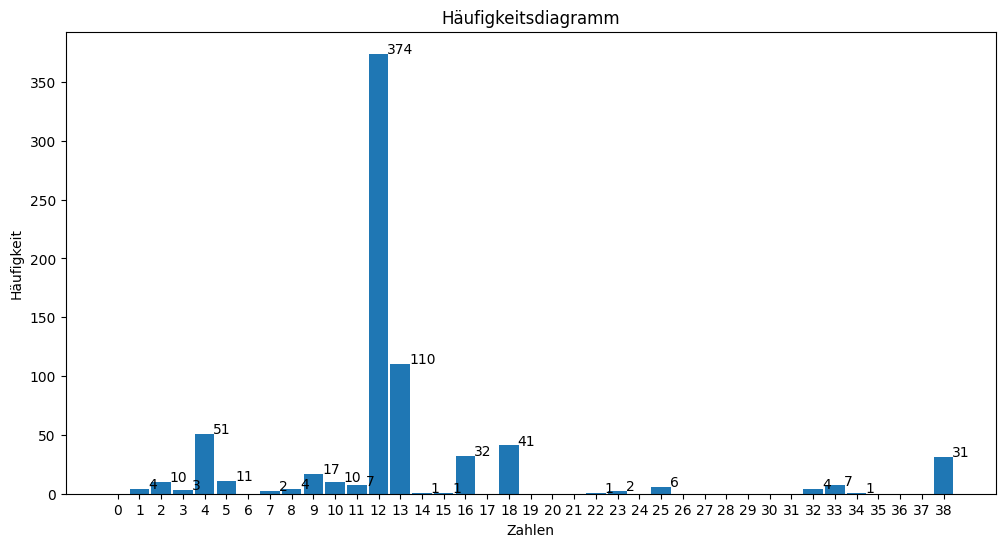

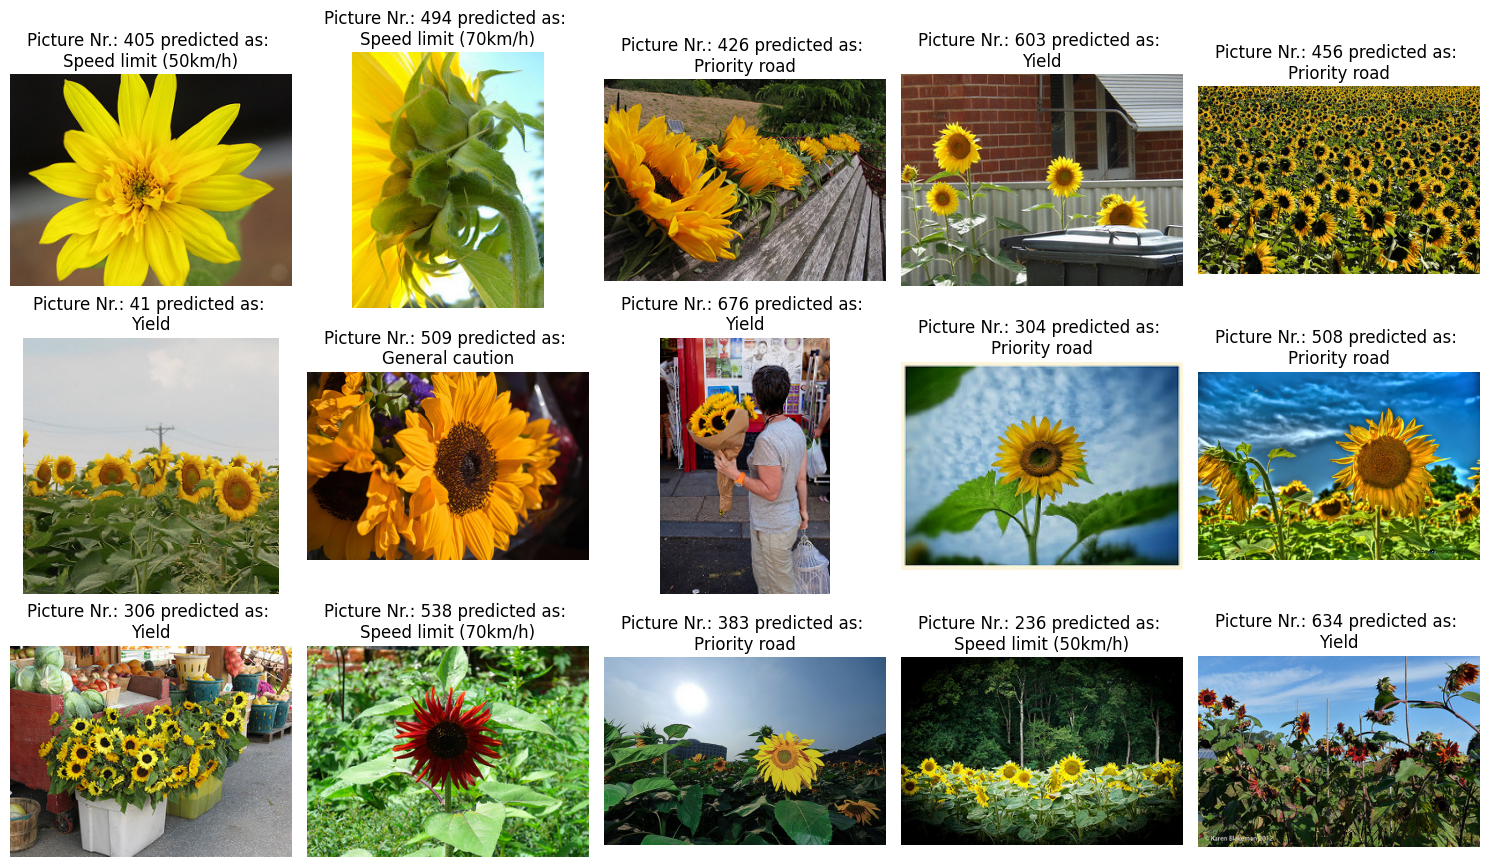

In [9]:
dataset_nr = 5
predictions = predictDataset(test_datasets[dataset_nr])
test_labels = test_datasets[dataset_nr]["test_lables"]

print("Accuracy: ", accuracy(predictions, test_labels))

frequencyChartPlot(predictions, test_labels, "recogized_as")
plotFalsePics(predictions, test_datasets[dataset_nr], val_data_paths[dataset_nr])

## MyTestBatch
Dieses besteht aus den Test Bildern die im GTSRB_dataset zu finden sind. Die Bilder waren zuvor unsortiert und mussten mithilfe einer CSV Datei sortiert und in die entsprechende Ordnerstruktur gebracht werden.

Accuracy:  0.7539849


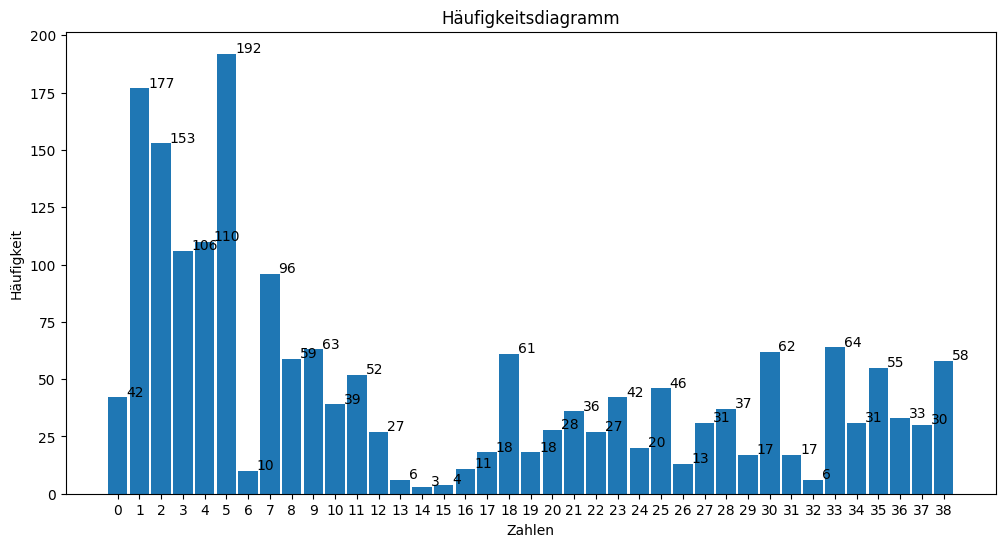

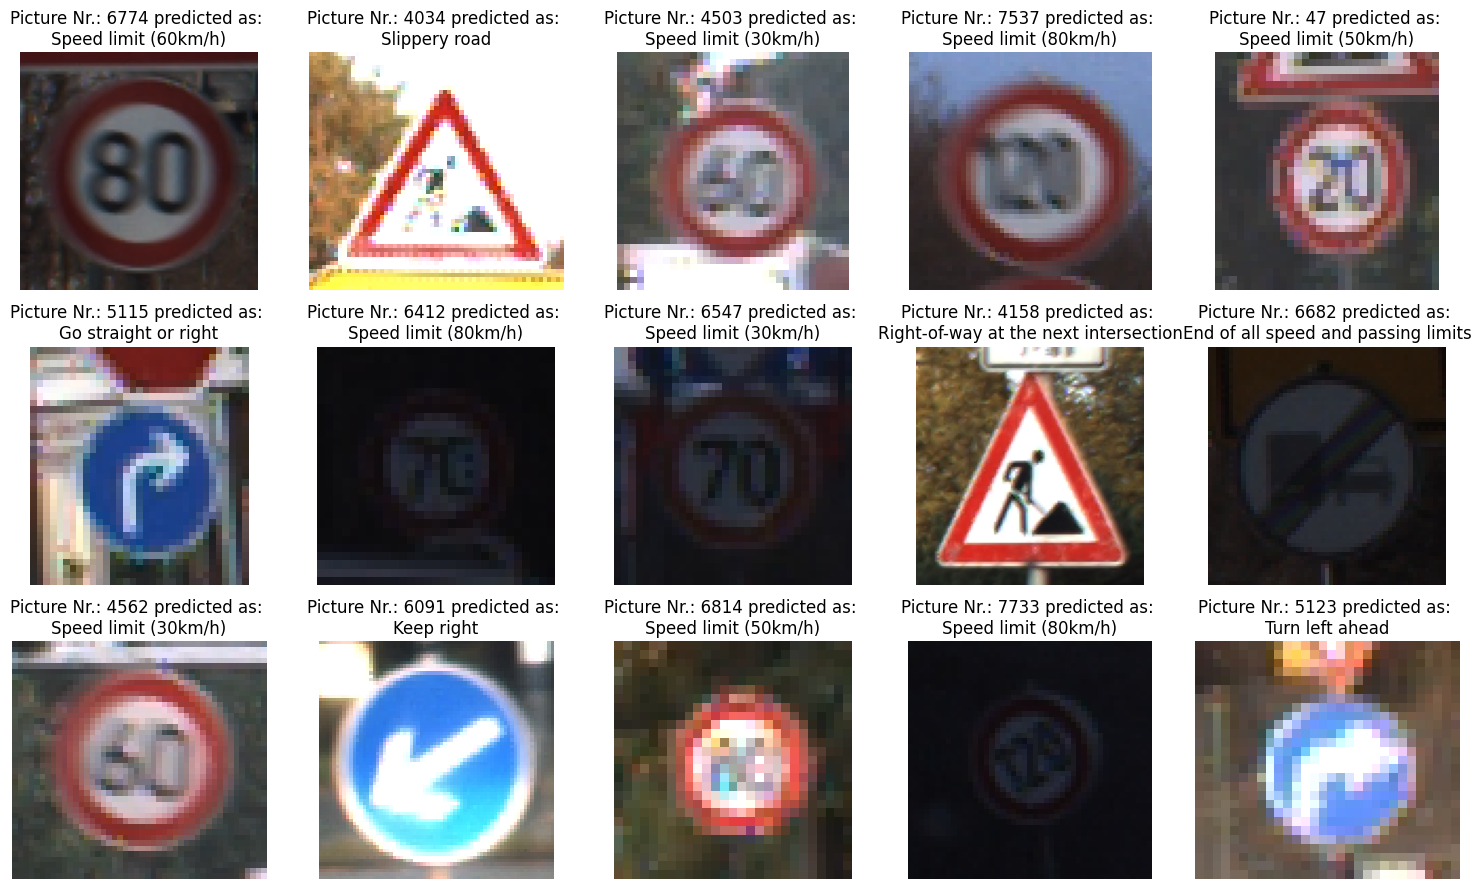

In [4]:
dataset_nr = 6
predictions = predictDataset(test_datasets[dataset_nr])
test_labels = test_datasets[dataset_nr]["test_lables"]

print("Accuracy: ", accuracy(predictions, test_labels))

frequencyChartPlot(predictions, test_labels, "false_singns")
plotFalsePics(predictions, test_datasets[dataset_nr], val_data_paths[dataset_nr])

Wie zu erwarten hat dieser Batch im Vergleich zu Batch 3 (was den Trainingsdaten entspricht) eine niedrigere Accuracy, 75% vs. 98%. Anhand der Ergebnisse dieses Batches werden im Folgenden die Effekte der Anpassungen bewertet. 